# Model Explainability with SHAP: A Guide to Those Who Are Serious About Machine Learning
# How to Explain Any Model With SHAP Even If You Are a Beginner
## Explain any black box model to non-technical people
![](https://cdn-images-1.medium.com/max/1350/1*TCsozDAfZrM2VjnwMID2zw.jpeg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@iriser?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Irina Iriser</a>
        on 
        <a href=https://www.pexels.com/photo/blue-and-red-jellyfish-artwork-1086583/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels''></a>
    </strong>
</figcaption>

# Setup

In [1]:
import logging
import time
import warnings

import catboost as cb
import datatable as dt
import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S", level=logging.INFO
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
pd.set_option("float_format", "{:.5f}".format)

2023-02-21 17:25:06.651734: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# For regression
diamonds = sns.load_dataset("diamonds")

X, y = diamonds.drop("price", axis=1), diamonds[["price"]].values.flatten()

# Encode cats
oe = OrdinalEncoder()
cats = X.select_dtypes(exclude=np.number).columns.tolist()
X.loc[:, cats] = oe.fit_transform(X[cats])

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.15, random_state=1121218
)

# Motivation

Today, you can't just come up to your boss and say, "Here is my best model. Let's put it into production and be happy!". No, it doesn't work that way now. Companies and businesses are being picky over adopting AI solutions because of their "black box" nature. They **demand** model explainability.

If ML specialists are coming up with tools to understand and explain the models *they* created, the concerns and suspicions of non-technical folks are entirely justified. One of those tools introduced a few years ago is SHAP. It can break down the mechanics of any machine learning model and deep neural net to make them understandable to anyone.

Today, we will learn how SHAP works and how you can use it for classical ML tasks in your practice.

![](https://cdn-images-1.medium.com/max/900/1*m0-c5e45bQH7bigxoSOnyQ.gif)

# What is SHAP and Shapley values?

SHAP (SHapley Additive exPlanations) is a Python package based on the 2016 NIPS paper about SHAP values. The premise of this paper and Shapley values comes from approaches in game theory.

One of the questions often posed in games is that in a group of n players with different skillsets, how do we divide a prize so that everyone gets a fair share based on their skill set? Depending on the number of players, their time of joining the game, and their different contributions to the outcome, this type of calculation can become horribly complex.

But what does game theory have to do with machine learning? Well, we could reframe the above question so that it becomes "Given a prediction, how do we most accurately measure each feature's contribution?" Yes, it is like asking feature importances of a model, but the answer the Shapley values give is much more sophisticated.

Specifically, Shapley values can help you in:
1. *Global model interpretability* - imagine you work for a bank and build a classification model for loan applications. Your manager wants you to explain what (and how) different factors influence the decisions of your model. Using SHAP values, you can give a concrete answer with details of which features lead to more loans and which features lead to more rejections. You make your manager happy because now, he can draw up basic guidelines for future bank customers to increase their chances of getting a loan. More loans mean more money means a happier manager means a higher salary for you.

![](https://cdn-images-1.medium.com/max/900/1*tLpb2EdoT_-ONIA9o1U7-g.png)

2. *Local interpretability* - your model rejects one of the applications submitted to the bank a few days ago. The customer claims he followed all the guidelines and was sure to get a loan from your bank. Now, you are legally obligated to explain why your model rejected that particular candidate. Using Shapley values, every case can be analyzed independently, without worrying about its connections to other samples in the data. In other words, you have local interpretability. You extract the Shapley values for the complaining customer and show them what parts of their application caused the rejection. You prove them wrong with a plot like this:

![](https://cdn-images-1.medium.com/max/900/1*HTUJCmyAfYfv7iv6-soGGg.png)


So, how do you calculate the mighty Shapley values? That's where we start using the SHAP package.

# How to calculate Shapley values with SHAP?

The exact mathematical details of calculating Shapley values deserve an article of its own. Therefore, for now, I will be standing on the shoulder of giants and refer you to their posts. They are guaranteed to solidify your understanding of the concepts ([1](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30), [2](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)). 

In practice, however, you will rarely refer to the math behind Shapley values. The reason is that all the magical details are nicely packaged inside SHAP. So, let's look at our very first example.

Using the Diamonds dataset built into Seaborn, we will be predicting diamond prices using several physical measurements. I processed the dataset beforehand and divided it into train and validation sets. Here is the training set:

In [3]:
X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
50250,0.73000,3.00000,4.00000,3.00000,62.50000,58.00000,5.73000,5.69000,3.57000
34529,0.33000,2.00000,3.00000,6.00000,61.70000,56.00000,4.45000,4.47000,2.75000
25048,0.30000,4.00000,2.00000,2.00000,63.50000,57.00000,4.26000,4.21000,2.69000
33207,0.40000,2.00000,6.00000,2.00000,61.20000,56.00000,4.77000,4.81000,2.93000
7051,0.33000,2.00000,5.00000,7.00000,62.40000,56.00000,4.41000,4.43000,2.76000


In [4]:
X_train.shape, X_valid.shape

((45849, 9), (8091, 9))

Cut, color, and clarity are categorical features. They are encoded ordinally as their orders have meaning to the context and, ultimately, the model decision.

As a baseline, we fit an XGBRegressor model and evaluate the performance with Root Mean Squared Error:

In [5]:
model = xgb.XGBRegressor(n_estimators=1000, tree_method="gpu_hist").fit(
    X_train, y_train
)

In [6]:
preds = model.predict(X_valid)
rmse = mean_squared_error(y_valid, preds, squared=False)

In [7]:
rmse

573.1740646253386

Now, let's finally take a peek behind the curtains and calculate the Shapley values for the training set.

We start by creating an explainer object for our model:

In [8]:
# Create a tree explainer
xgb_explainer = shap.TreeExplainer(
    model, X_train, feature_names=X_train.columns.tolist()
)

In [9]:
xgb_explainer

`TreeExplainer` is a special class of SHAP, optimized to work with any tree-based model in Sklearn, XGBoost, LightGBM, CatBoost, and so on. You can use `KernelExplainer` for any other type of model, though it is slower than tree explainers.

This tree explainer has many methods, one of which is `shap_values`:

In [10]:
%%time

# Shap values with tree explainer
shap_values = xgb_explainer.shap_values(X_train, y_train)

100%|===================| 45827/45849 [32:12<00:00]       

CPU times: user 32min 5s, sys: 5.3 s, total: 32min 10s
Wall time: 32min 14s


In [11]:
shap_values.shape

(45849, 9)

As I have said, calculating Shapley values is a complex process, which is why it took ~22 mins (local machine) for just 45k observations on the CPU. For large modern datasets with hundreds of features and millions of samples, the calculation can take days. So, we turn to GPUs to calculate the SHAP values.

As of now, GPU support is not stable in SHAP, but we have a workaround. The `predict` method of the core XGBoost model has `pred_contribs` argument, which, when set to True, calculates SHAP values on GPUs:

In [12]:
%%time

# Shap values with XGBoost core moedl
booster_xgb = model.get_booster()
shap_values_xgb = booster_xgb.predict(xgb.DMatrix(X_train, y_train), pred_contribs=True)

CPU times: user 1.48 s, sys: 9 ms, total: 1.49 s
Wall time: 1.47 s


> Note that LightGBM also has GPU support for SHAP values in its `predict` method. In CatBoost, it is achieved by calling `get_feature_importances` method on the model with `type` set to `ShapValues`.

After extracting the core booster model of XGBoost, it only took about a second to calculate Shapley values for 45k samples:

In [13]:
shap_values_xgb.shape

(45849, 10)

But wait - the Shap values from the tree explainer had nine columns; this one has 10! Don't worry; we can safely ignore the last column for now, as it just contains the bias term which XGBoost adds by default:

In [14]:
shap_values_xgb = shap_values_xgb[:, :-1]

pd.DataFrame(shap_values_xgb, columns=X_train.columns.tolist()).head()

,carat,cut,color,clarity,depth,table,x,y,z
0,-388.86169,-6.58120,-155.43312,-560.26898,49.76458,25.40068,261.11359,-1010.61786,-15.96519
1,-2044.05505,48.72814,-10.71871,847.29340,3.22687,9.97491,-106.12584,-1536.66882,-279.21860
2,-1811.66980,-2.53238,166.51955,-223.18399,-45.71909,-15.89721,-57.74437,-1079.10828,-216.13190
3,-1468.32117,50.83697,-565.60767,-165.40787,12.61621,2.59791,97.34766,-1064.47241,-174.62039
4,-1826.17810,40.15614,-492.27109,544.16931,-12.68207,-3.94350,-29.28057,-1302.26038,-256.01337


We got the Shapley values; now what? Now, we get plottin'.

# Global Feature Importances with SHAP

Let's see which physical measurements of diamonds are the most important when determining price:

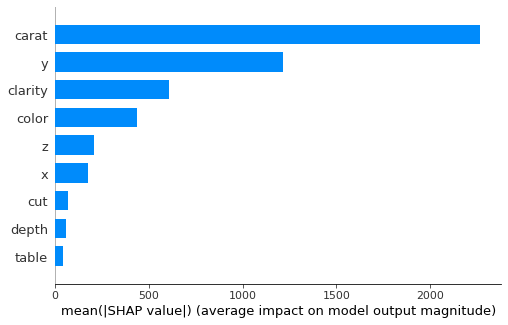

In [15]:
shap.summary_plot(
    shap_values_xgb, X_train, feature_names=X_train.columns, plot_type="bar"
)

The carat stands out as the driving factor for a diamond's price. Reading the axis title below, we see that the importances are just the average absolute Shapley values for a feature. We can check that below:

In [16]:
pd.DataFrame(shap_values_xgb, columns=X_train.columns)["carat"].abs().mean()

2268.127197265625

But that's not much different than the feature importances plot you would get from XGBoost:

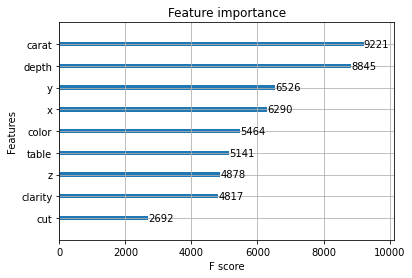

In [17]:
xgb.plot_importance(booster_xgb);

That's where we are wrong. You can't trust feature importances from XGBoost because they are inconsistent across different calculations. Watch how feature importances change with the calculation type:

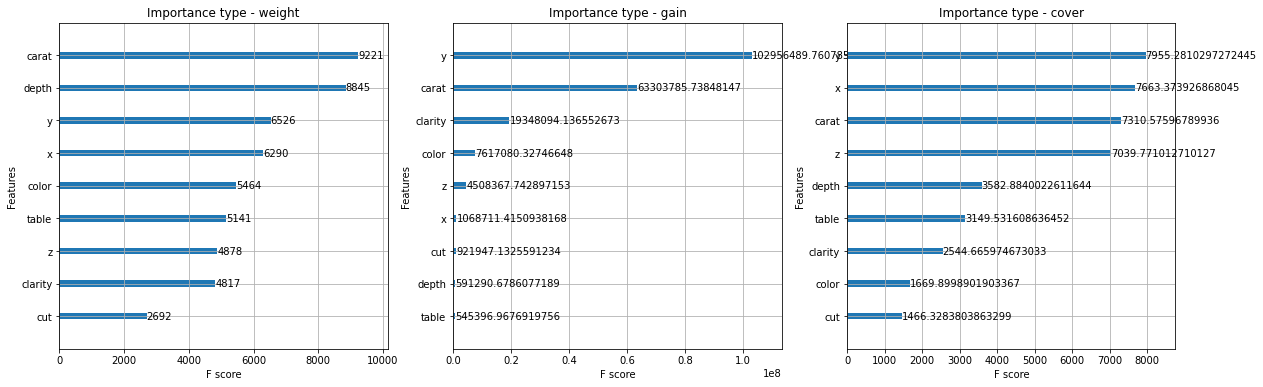

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, imp_type in zip(axes.flatten(), ["weight", "gain", "cover"]):
    xgb.plot_importance(
        booster_xgb,
        ax=ax,
        importance_type=imp_type,
        title=f"Importance type - {imp_type}",
    )

plt.show();

In contrast, feature importances obtained from Shapley values are consistent and trustworthy.

We won't also stop here. In the above plots, we only looked at absolute values of importance. We don't know which feature positively or negatively influences the model. Let's do that with SHAP `summary_plot`:

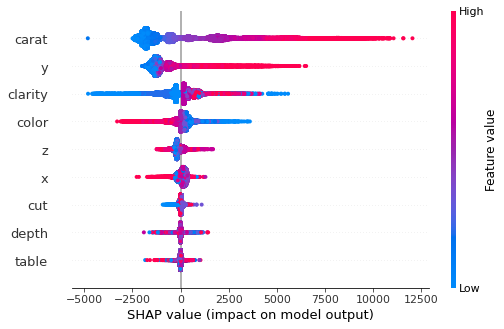

In [19]:
shap.summary_plot(shap_values_xgb, X_train, feature_names=X_train.columns);

Here is how to interpret the above plot:

1. The left vertical axis denotes feature names, ordered based on importance from top to bottom.
2. The horizontal axis represents the magnitude of the SHAP values for predictions.
3. The vertical right axis represents the actual magnitude of a feature as it appears in the dataset and colors the points.

We see that as carat increases, its effect on the model is more positive. The same is true for y feature. The x and z features are a bit tricky with a cluster of mixed points around the center.

# Exploring each feature with dependence plots

We can get a deeper insight into each feature's effect on the entire dataset with dependence plots. Let's see an example and explain it later:

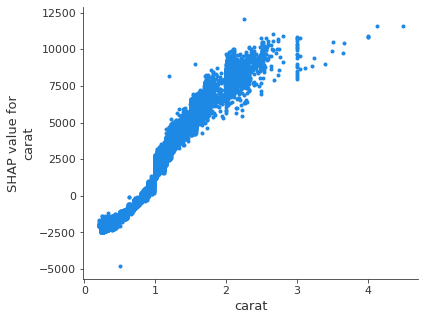

In [20]:
shap.dependence_plot("carat", shap_values_xgb, X_train, interaction_index=None)

This plot aligns with what we saw in the summary plot before. As carat increases, its SHAP value increases. By changing the `interaction_index` parameter to `auto`, we can color the points with a feature that most strongly interacts with carat:

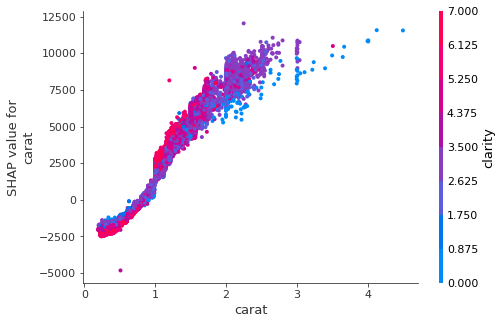

In [21]:
shap.dependence_plot("carat", shap_values_xgb, X_train, interaction_index="auto");

It seems that the carat interacts with the clarity of the diamonds much stronger than other features.

Let's now create a dependence plot for categorical features:

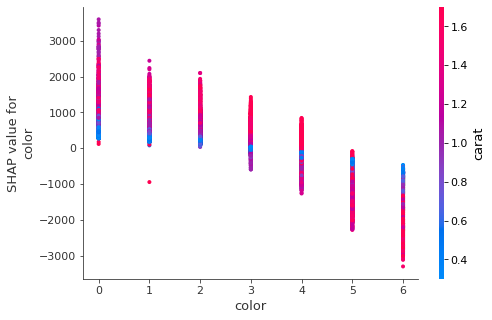

In [22]:
shap.dependence_plot("color", shap_values_xgb, X_train, feature_names=X_train.columns);

This plot also goes in hand with the summary plot. The latest color categories affect the prices negatively while interacting with carat.

I will let you explore the dependence plots for other features below:

<p float="left">
  <img src="https://cdn-images-1.medium.com/max/450/1*D5bClhlRvUfPTT-D41jBEw.png" width="250" height="250"/>
  <img src="https://cdn-images-1.medium.com/max/450/1*2z6GYbYhCAZujHw3_0GFcQ.png" width="250" height="250"/> 
  <img src="https://cdn-images-1.medium.com/max/450/1*rjecV-75_5YftqCKeyNEZA.png" width="250" height="250"/>
</p>
<p float="left">
  <img src="https://cdn-images-1.medium.com/max/450/1*pM59RXcHnHY5x-OOgYfgSw.png" width="250" height="250"/>
  <img src="https://cdn-images-1.medium.com/max/450/1*5F59k8ujenHhYqWLCGhGjg.png" width="250" height="250"/>
  <img src="https://cdn-images-1.medium.com/max/450/1*EMZLpKV1pPaXcNP5W--acg.png" width="250" height="250"/>
</p>

# Feature Interactions with Shapley values

One of the most fantastic attributes of SHAP and Shapley values is their ability to find relationships between features accurately. We have already got a taste of that in the last section when SHAP found the most robust interacting feature in dependence plots.

We can go a step further and find all feature interactions ordered by their interaction strength. For that, we need a different set of values - SHAP interaction values.

They can be calculated using the `shap_interaction_values` of the tree explainer object like so:

```python
interactions = xgb_explainer.shap_interaction_values(X_train, y)
```

but this is even more time-consuming than regular SHAP values. So, we will turn to GPUs once more with XGBoost:

In [23]:
%%time

# SHAP interactions with XGB
interactions_xgb = booster_xgb.predict(
    xgb.DMatrix(X_train, y_train), pred_interactions=True
)

CPU times: user 11.6 s, sys: 41.9 ms, total: 11.7 s
Wall time: 11.7 s


By setting `pred_interactions` to True, we get SHAP interaction values in only 12 seconds. It is a 3D array, with the last column axes being the bias terms:

In [24]:
interactions_xgb.shape

(45849, 10, 10)

Now we got the interactions; what do we do? Frankly, even the SHAP documentation doesn't outline a reasonable use-case for interactions, but we get help from others. Specifically, we will use a function I have learned from [4x Kaggle Grandmaster Bojan Tunguz](https://www.kaggle.com/tunguz) to find the strongest feature interactions in our dataset and plot them:

In [25]:
def get_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (
                        feature_names[i] + "-" + feature_names[j],
                        aggregate_interactions[i][j] * 2,
                    )
                )
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))

    return interaction_features[:k], interaction_values[:k]


top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(
    X_train.columns, interactions_xgb, 10
)

Now, `top_10_inter_feats` contains 10 of the strongest interactions between all possible pairs of features:

In [26]:
top_10_inter_feats

('y-carat',
 'y-clarity',
 'color-carat',
 'clarity-carat',
 'y-x',
 'z-carat',
 'y-color',
 'clarity-color',
 'x-carat',
 'z-y')

We can create another function that plots these pairs based on their interaction strengths:

In [27]:
def plot_interaction_pairs(pairs, values):
    plt.bar(pairs, values)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show();

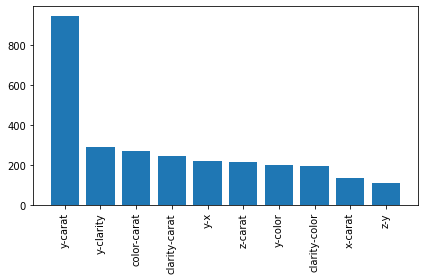

In [28]:
top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(
    X_train.columns, interactions_xgb, 10
)

plot_interaction_pairs(top_10_inter_feats, top_10_inter_vals)

As we can see, the interactions between y and carat is much stronger than others. Even though this plot doesn't mean anything to us, it might be possible for a domain expert to decipher this relationship and use it to diagnose the model better.

For example, if your model tried to classify molecules' reactions to different chemical stimuli, a plot like this can be helpful because it might show which chemical properties of the molecules are interacting with the stimulus. This will tell a lot to the domain expert running the experiments since they know what types of chemicals interact and whether the model could capture their behavior.

# Local interpretability

Finally, we get to the local interpretability section. It is all about explaining why the model got to a particular decision for a sample.

Let's choose a random diamond and its predicted price to explain:

In [29]:
random_idx = np.random.randint(len(X_train))
random_idx

14900

OK, it looks like we will be looking at the 6559th (changed because of random seed) diamond in the training data. Let's start:

In [30]:
%%time

# Recalculate SHAP values
shap_explainer_values = xgb_explainer(X_train, y_train)

100%|===================| 45825/45849 [32:04<00:01]       

CPU times: user 31min 57s, sys: 5.07 s, total: 32min 2s
Wall time: 32min 7s


We first recalculate the SHAP values using the explainer object. This is different than `shap_values` function, because this time, the Shapley values are returned with a few more properties we need for local interpretability:

In [31]:
type(shap_explainer_values)

shap._explanation.Explanation

Now, let's explain the random diamond we picked out with a waterfall plot:

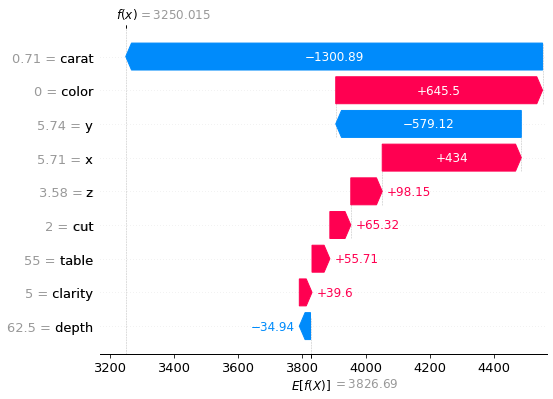

In [32]:
shap.waterfall_plot(shap_explainer_values[6559])

The `E[f(x)] = 3826.69` is the mean prediction of diamond prices for the train set, e.g. `preds.mean()`.  The `f(x) = 3250.015` is the predicted price for the diamond.

The thin line in the middle denotes the mean prediction. The vertical axis shows the feature values of the 6559th diamond. The bars represent how each feature property shifted the price from the mean prediction. The red bars represent positive shifts; the blue bars represent negative shifts.

Let's look at another diamond for completeness:

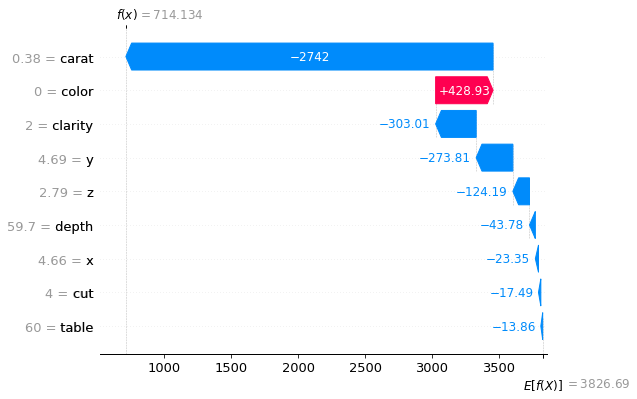

In [33]:
shap.waterfall_plot(shap_explainer_values[4652])

This diamond is much cheaper than the previous one, mainly because its carat is much lower, as can be seen above.

There is another plot to explain local interpretability. The SHAP calls it force plot, and it looks like this:

In [34]:
shap.initjs()  # don't forget to enable JavaScript

shap.force_plot(shap_explainer_values[4652])

This is just an ordered, organized version of waterfall plots. All negative and positive bars are grouped to either side of the predicted price. Again, the base value shows the mean price, and the bars show how much each feature property shifts that value.

In [35]:
shap.force_plot(shap_explainer_values[6559])

# Summary

Now, you can come up to your boss and say, "Here is my best model, and here is the explanation of why it is the best and how it works. Let's put it into production and be happy!" Hopefully, the response you get will be much more positive.

![medium_cta.gif](https://cdn-images-1.medium.com/max/900/1*KeMS7gxVGsgx8KC36rSTcg.gif)